In [2]:
#!pip install -r requirements.txt

In [1]:
import sys
sys.path.append("lib/src/")
from autogen_utils import AnthropicClient

config_list_claude = [
    {
        "model": "anthropic.claude-3-sonnet-20240229-v1:0",
        "api_type": "anthropic",
        "model_client_cls": "AnthropicClient",
        "cache_seed" : None, #we deactivate the cache on purpose
    }
]

#see below the 2 main modifications that we have to include into the code to make that Anthropic wrapper work in the code

#llm_config={"config_list": config_list_claude}
#agent.register_model_client(model_client_cls=AnthropicClient)

# Code Executors

In the last chapter, 
we used two agents powered by a large language model (LLM) to play a game
by exchanging messages.
In this chapter, we introduce code executors, which enable agents to not just chat
but also
to interact with an environment and perform useful computations and take actions.

## Overview

In AutoGen, a code executor is a component that
takes input messages (e.g., those containing code blocks), performs execution, and outputs messages
with the results.
AutoGen provides two types of built-in code executors, one is 
command line code executor, which runs code in a command line environment
such as a UNIX shell, and the other is Jupyter executor, which runs code
in an interactive [Jupyter kernel](https://github.com/jupyter/jupyter/wiki/Jupyter-kernels).

For each type of executor, AutoGen provides two ways to execute code: locally and in a Docker container.
One way is to execute
code directly in the same host platform where AutoGen is running, i.e.,
the local operating system.
It is for development and testing, but it is not ideal for production
as LLM can generate arbitrary code.
The other way is to execute code in a Docker container.
The table below shows the combinations of code executors and execution
environments.

| Code Executor (`autogen.coding`) | Environment | Platform |
| ---------------------------- | ----------- | -------- |
| [`LocalCommandLineCodeExecutor`](/docs/reference/coding/local_commandline_code_executor#localcommandlinecodeexecutor)  | Shell       | Local  |
| [`DockerCommandLineCodeExecutor`](/docs/reference/coding/docker_commandline_code_executor#dockercommandlinecodeexecutor) | Shell       | Docker |
| [`jupyter.JupyterCodeExecutor`](/docs/reference/coding/jupyter/jupyter_code_executor#jupytercodeexecutor)           | Jupyter Kernel (e.g., python3) | Local/Docker |

In this chapter, we will focus on the command line code executors.
For the Jupyter code executor, please refer to the topic page for 
[Jupyter Code Executor](../topics/code-execution/jupyter-code-executor).

## Local Execution

The figure below shows the architecture of the local command line code executor
([`autogen.coding.LocalCommandLineCodeExecutor`](/docs/reference/coding/local_commandline_code_executor#localcommandlinecodeexecutor)).

````mdx-code-block
:::danger
Executing LLM-generated code poses a security risk to your host environment.
:::
````


![Code Executor No Docker](./assets/code-executor-no-docker.png)


Upon receiving a message with a code block, the local command line code executor
first writes the code block to a code file, then starts a new subprocess to
execute the code file. The executor reads the console output of the 
code execution and sends it back as a reply message.

Here is an example of using the code executor to run a Python
code block that prints a random number.
First we create an agent with the code executor
that uses a temporary directory to store the code files.
We specify `human_input_mode="ALWAYS"` to manually validate the safety of the the code being 
executed.

In [2]:
import tempfile
import os

from autogen import ConversableAgent
from autogen.coding import LocalCommandLineCodeExecutor

# Get the current working directory
cwd = os.getcwd()

# Create a temporary directory with .tmp extension in the current directory
temp_dir = tempfile.TemporaryDirectory(prefix="", dir=cwd, suffix=".tmp")

# Create a local command line code executor.
executor = LocalCommandLineCodeExecutor(
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=temp_dir.name,  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": executor},  # Use the local command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

Before running this example, we need to make sure the `matplotlib` and `numpy`
are installed.

In [3]:
! pip install -qqq matplotlib numpy

Now we have the agent generate a reply given a message with a Python code block.

In [4]:
message_with_code_block = """This is a message with code block.
The code block is below:
```python
import numpy as np
import matplotlib.pyplot as plt
x = np.random.randint(0, 100, 100)
y = np.random.randint(0, 100, 100)
plt.scatter(x, y)
plt.savefig('scatter.png')
print('Scatter plot saved to scatter.png')
```
This is the end of the message.
"""

# Generate a reply for the given code.
reply = code_executor_agent.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: Scatter plot saved to scatter.png



During the generation of response, a human input is requested to give an opportunity
to intercept the code execution.
In this case, we choose to continue the execution, 
and the agent's reply contains the output of the code execution.

We can take a look at the generated plot in the temporary directory.

In [5]:
import os
print(temp_dir.name)
print(os.listdir(temp_dir.name))
# We can see the output scatter.png and the code file generated by the agent.

/Users/rvvivier/Library/CloudStorage/WorkDocsDrive-Documents/code/autogen/da4bzzzy.tmp
['tmp_code_e24bf32d4a21990fb9e4b5eb889ebe5a.py', 'scatter.png']


Clean up the working directory to avoid affecting future conversations.

## Docker Execution

To mitigate the security risk of running LLM-generated code locally, 
we can use the docker command line code executor 
([`autogen.coding.DockerCommandLineCodeExecutor`](/docs/reference/coding/docker_commandline_code_executor#dockercommandlinecodeexecutor))
to execute code in a docker container.
This way, the generated code can only access resources that are explicitly 
given to it.

The figure below illustrates how does the docker execution works.


![Code Executor Docker](./assets/code-executor-docker.png)


Similar to the local command line code executor, the docker executor 
extracts code blocks from input messages, writes them to code files.
For each code file, it starts a docker container to execute the code file,
and reads the console output of the code execution.

To use docker execution, you need to [install Docker](https://docs.docker.com/engine/install/) on your machine.
Once you have Docker installed and running, you can set up your code executor agent as follow:

In [6]:
from autogen.coding import DockerCommandLineCodeExecutor


# Create a Docker command line code executor.
executor = DockerCommandLineCodeExecutor(
    image="python:3.12-slim",  # Execute code using the given docker image name.
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=temp_dir.name,  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration that uses docker.
code_executor_agent_using_docker = ConversableAgent(
    "code_executor_agent_docker",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": executor},  # Use the docker command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

# When the code executor is no longer used, stop it to release the resources.
# executor.stop()

The `work_dir` in the constructor points to a local file system directory just like in the local execution case.
The docker container will mount this directory and the executor write code files
and output to it.

## Use Code Execution in Conversation

Writing and executing code is necessary for many tasks such as 
data analysis, machine learning, and mathematical modeling.
In AutoGen, coding can be a conversation between a code writer agent and a 
code executor agent, mirroring the interaction between a programmer and a
code interpreter.

```{=mdx}
![Code Writer and Code Executor](./assets/code-execution-in-conversation.png)
```

The code writer agent can be powered by an LLM such as GPT-4 with code-writing
capability.
And the code executor agent is powered by a code executor.

The following is an agent with a code writer role specified 
using `system_message`. The system message contains important instruction
on how to use the code executor in the code executor agent.

In [7]:
# The code writer agent's system message is to instruct the LLM on how to use
# the code executor in the code executor agent.
code_writer_system_message = """You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.
Reply 'TERMINATE' in the end when everything is done.
"""

code_writer_agent = ConversableAgent(
    "code_writer_agent",
    system_message=code_writer_system_message,
    llm_config={"config_list": config_list_claude},
    code_execution_config=False,  # Turn off code execution for this agent.
)

#added
code_writer_agent.register_model_client(model_client_cls=AnthropicClient)

[autogen.oai.client: 04-29 19:27:09] {426} INFO - Detected custom model client in config: AnthropicClient, model client can not be used until register_model_client is called.


Here is an example of solving a math problem through a conversation
between the code writer agent and the code executor agent (created above).

In [8]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message="Write Python code to calculate the 14th Fibonacci number.",
)

code_executor_agent (to code_writer_agent):

Write Python code to calculate the 14th Fibonacci number.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

Here's a Python script to calculate the 14th Fibonacci number:

```python
# filename: fibonacci.py
def fibonacci(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

print(fibonacci(14))
```

To explain:
1. The `fibonacci` function calculates the nth Fibonacci number using recursion.
2. The base cases are: if `n` is 0 or negative, return 0; if `n` is 1, return 1.
3. For any other positive `n`, the nth Fibonacci number is calculated as the sum of the (n-1)th and (n-2)th Fibonacci numbers.
4. Finally, we call `fibonacci(14)` and print the result, which is the 14th Fibonacci number.

Let me know if you need any clarification or have additional requirements!

-

During the previous chat session, human input was requested each time
the code executor agent responded to ensure that the code was safe to execute.

Now we can try a more complex example that involves querying the web.
Let's say we want to get the the stock price gains year-to-date for
Tesla and Meta (formerly Facebook). We can also use the two agents
with several iterations of conversation.


In [9]:
import datetime

today = datetime.datetime.now().strftime("%Y-%m-%d")
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}. Write Python code to plot TSLA's and META's "
    "stock price gains YTD, and save the plot to a file named 'stock_gains.png'.",
)

code_executor_agent (to code_writer_agent):

Today is 2024-04-29. Write Python code to plot TSLA's and META's stock price gains YTD, and save the plot to a file named 'stock_gains.png'.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

```python
# filename: stock_gains.py
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Get current date
today = datetime.now().date()
year = today.year

# Download stock data from Yahoo Finance
tsla = pd.DataReader('TSLA', 'yahoo', start=f'{year}-01-01', end=today)
meta = pd.DataReader('META', 'yahoo', start=f'{year}-01-01', end=today)

# Calculate year-to-date gains
tsla_start = tsla['Adj Close'][0]
tsla_gain = (tsla['Adj Close'][-1] - tsla_start) / tsla_start * 100

meta_start = meta['Adj Close'][0]  
meta_gain = (meta['Adj Close'][-1] - meta_start) / meta_start * 100

# Plot the gains
plt.figure(figsize=(8, 6))


In the previous conversation, the code writer agent generated a code block
to install necessary packages and another code block for a script to 
fetch the stock price and calculate gains year-to-date for Tesla and Meta.
The code executor agent installed the packages, executed the script, 
and returned the results.

Let's take a look at the chart that was generated.

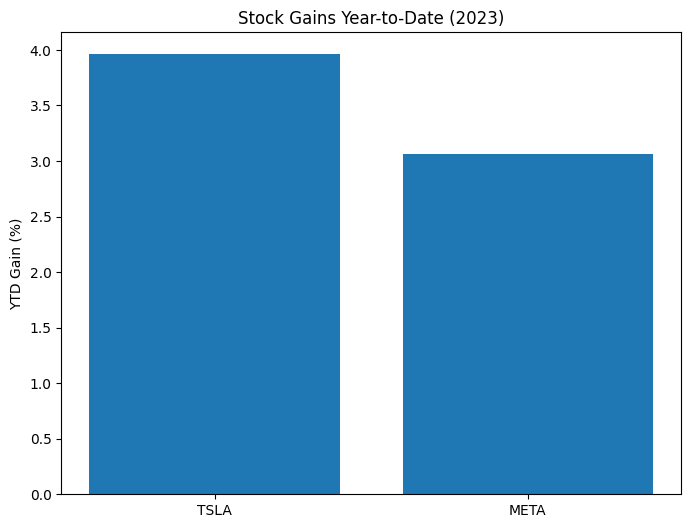

In [11]:
from IPython.display import Image

Image(os.path.join(temp_dir.name, "stock_gains.png"))

Because code execution leave traces like code files and output in the file system, 
we may want to clean up the working directory after each conversation concludes.

In [12]:
temp_dir.cleanup()

Stop the docker command line executor to clean up the docker container.

In [13]:
executor.stop()  # Stop the docker command line code executor.

## Command Line or Jupyter Code Executor?

The command line code executor does not keep any state in memory between
executions of different code blocks it receives, as it writes each code block to
a separate file and executes the code block in a new process.

Contrast to the command line code executor, the Jupyter code executor
runs all code blocks in the same Jupyter kernel, which keeps the state
in memory between executions.
See the topic page for [Jupyter Code Executor](../topics/code-execution/jupyter-code-executor).

The choice between command line and Jupyter code executor depends on the
nature of the code blocks in agents' conversation.
If each code block is a "script" that does not use variables from
previous code blocks, the command line code executor is a good choice.
If some code blocks contain expensive computations (e.g., training a
machine learning model and loading a large amount of data), and you want to
keep the state in memory to avoid repeated computations,
the Jupyter code executor is a better choice.

## Note on User Proxy Agent and Assistant Agent

### User Proxy Agent

In the previous examples, we create the code executor agent directly using
the [`ConversableAgent`](/docs/reference/agentchat/conversable_agent#conversableagent) class. Existing AutoGen examples often create 
code executor agent using the [`UserProxyAgent`](/docs/reference/agentchat/user_proxy_agent#userproxyagent) class, 
which is a subclass of
[`ConversableAgent`](/docs/reference/agentchat/conversable_agent#conversableagent) with `human_input_mode=ALWAYS` and `llm_config=False` --
it always requests human input for every message and does not use LLM.
It also comes with default `description` field for each of the
`human_input_mode` setting.
This class is a convenient short-cut for creating an agent that is
intended to be used as a code executor.


### Assistant Agent

In the previous examples, we created the code writer agent directly using
the [`ConversableAgent`](/docs/reference/agentchat/conversable_agent#conversableagent) class. Existing AutoGen examples often create the code writer
agent using the [`AssistantAgent`](/docs/reference/agentchat/assistant_agent#assistantagent) class, which is a subclass of
[`ConversableAgent`](/docs/reference/agentchat/conversable_agent#conversableagent) with `human_input_mode=NEVER` and `code_execution_config=False` 
-- it never requests human input and does not use code executor.
It also comes with default `system_message` and `description` fields.
This class is a convenient short-cut for creating an agent that is
intended to be used as a code writer and does not execute code.

In fact, in the previous example we use the default `system_message` field
of the [`AssistantAgent`](/docs/reference/agentchat/assistant_agent#assistantagent) class to instruct the code writer agent how to use
code executor.

In [14]:
import pprint

from autogen import AssistantAgent

pprint.pprint(AssistantAgent.DEFAULT_SYSTEM_MESSAGE)

('You are a helpful AI assistant.\n'
 'Solve tasks using your coding and language skills.\n'
 'In the following cases, suggest python code (in a python coding block) or '
 'shell script (in a sh coding block) for the user to execute.\n'
 '    1. When you need to collect info, use the code to output the info you '
 'need, for example, browse or search the web, download/read a file, print the '
 'content of a webpage or a file, get the current date/time, check the '
 'operating system. After sufficient info is printed and the task is ready to '
 'be solved based on your language skill, you can solve the task by yourself.\n'
 '    2. When you need to perform some task with code, use the code to perform '
 'the task and output the result. Finish the task smartly.\n'
 'Solve the task step by step if you need to. If a plan is not provided, '
 'explain your plan first. Be clear which step uses code, and which step uses '
 'your language skill.\n'
 'When using code, you must indicate the scrip

### Best Practice

It is very important to note that the [`UserProxyAgent`](/docs/reference/agentchat/user_proxy_agent#userproxyagent) and [`AssistantAgent`](/docs/reference/agentchat/assistant_agent#assistantagent)
are meant to be shortcuts to avoid writing the `system_message` instructions
for the [`ConversableAgent`](/docs/reference/agentchat/conversable_agent#conversableagent) class. 
They are not suitable for all use cases.
As we will show in the next chapter, tuning the 
`system_message` field
is vital for agent to work properly in more complex conversation patterns
beyond two-agent chat.

As a best practice, always tune your agent's `system_message` instructions
for your specific use case and avoid subclassing [`UserProxyAgent`](/docs/reference/agentchat/user_proxy_agent#userproxyagent) and
[`AssistantAgent`](/docs/reference/agentchat/assistant_agent#assistantagent).

## Summary

In this chapter, we introduced code executors, how to set up Docker and local
execution, and how to use code execution in a conversation to solve tasks.
In the next chapter, we will introduce tool use, which is similar to code
executors but restricts what code an agent can execute.